In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, Image
import ipywidgets
import numpy
import pandas
from matplotlib import cm, pyplot

import calibr8
import dataloading
import models
import plotting

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


### Read the data

In [3]:
df_layout = dataloading.get_layout(r"multibatch\FullWellDescription.xlsx")

df_layout = df_layout[~pandas.isna(df_layout.group)]

df_time, df_A360, df_A600 = dataloading.vectorize_observations(
    df_layout,
    observations={
         "Carboxylase_19": (
             dataloading.read_absorbances(r"multibatch\Carboxylase_19_360nm.csv"),
             dataloading.read_absorbances(r"multibatch\Carboxylase_19_600nm.csv"),
         ),
         "Carboxylase_20": (
             dataloading.read_absorbances(r"multibatch\Carboxylase_20_360nm.csv"),
             dataloading.read_absorbances(r"multibatch\Carboxylase_20_600nm.csv"),
         ),
        "Carboxylase_21": (
             dataloading.read_absorbances(r"multibatch\Carboxylase_19_360nm.csv"),
             dataloading.read_absorbances(r"multibatch\Carboxylase_19_600nm.csv"),
         ),
    }
)

display(df_layout.head())
display(df_A360.head())

,run,assay_well,reactor,group,product,biomass
replicate_id,,,,,,
CQYRX,Carboxylase_21,A01,A1,"0,75µM/1,0gL-1",NaN,NaN
E1YF9,Carboxylase_21,A02,A2,"3,75µM/1,0gL-1",NaN,NaN
5453N,Carboxylase_21,A03,A3,"0,75µM/1,5gL-1",NaN,NaN
HWPYC,Carboxylase_21,A04,A4,"3,75µM/1,5gL-1",NaN,NaN
T3AH7,Carboxylase_21,A05,A5,"0,75µM/2,0gL-1",NaN,NaN


cycle,0,1,2,3,4
replicate_id,,,,,
CQYRX,0.571,0.869,1.153,1.488,2.132
E1YF9,0.558,0.847,1.122,1.575,2.029
5453N,0.579,0.896,1.172,1.476,2.018
HWPYC,0.546,0.897,1.184,1.507,2.017
T3AH7,0.640,0.949,1.237,1.496,1.899


In [4]:
def plot_content(group: str):
    fig, axs = pyplot.subplots(ncols=2, figsize=(12, 4), dpi=140, sharex=True)

    rids = df_layout[df_layout["group"] == group].index
    ax = axs[0]
    ax.plot(df_time.loc[rids].T, df_A360.loc[rids].T, label="360 nm")
    ax.set(
        ylabel="absorbance at 360 mm",
        xlabel="time   [h]",
        ylim=(0, 2.5),
    )

    ax = axs[1]
    ax.plot(df_time.loc[rids].T, df_A600.loc[rids].T, label="600 nm")
    ax.set(
        ylabel="absorbance at 600 mm",
        xlabel="time   [h]",
        ylim=(0, 1),
        xlim=(0, None),
    )
    fig.tight_layout()
    pyplot.show()
    
ipywidgets.interact(
    plot_content,
    group=numpy.unique(df_layout["group"].dropna())
);

interactive(children=(Dropdown(description='group', options=('0,15µM', '0,20µM', '0,25µM', '0,30µM', '0,40µM',…

### Empirical observations to motivate further analyses

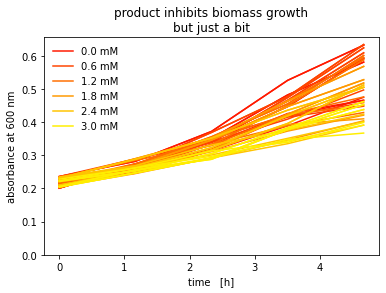

In [5]:
plotting.plot_calibration_biomass_observations(df_layout, df_A600, df_time)

### Prepare calibration models

Because we don't have a proper biomass calibration, well assume some proportionalities:

$$A_{600} \propto X$$
$$A_{360} \propto X$$

In [6]:
calibration_rids = df_layout[~df_layout["product"].isna()].index
df_rel_biomass = (df_A600.loc[calibration_rids].T / df_A600.loc[calibration_rids, 0]).T
df_rel_biomass

cycle,0,1,2,3,4
replicate_id,,,,,
TMKHP,1.0,1.275862,1.694581,2.201970,2.916256
TH4E8,1.0,1.333333,1.746269,2.398010,2.890547
17ZY9,1.0,1.194915,1.576271,2.228814,2.677966
LA7HD,1.0,1.176211,1.511013,2.052863,2.682819
ZDKXD,1.0,1.363184,1.686567,2.358209,3.104478
BADAN,1.0,1.251163,1.716279,2.218605,2.948837
NQ433,1.0,1.226852,1.537037,2.083333,2.722222
W7X8W,1.0,1.275701,1.663551,2.126168,2.808411
81RQM,1.0,1.244240,1.612903,2.133641,2.741935


Parameter df (30.0) is close to its upper bound (30).
Fit of LinearBiomassAbsorbanceModel has failed:
      fun: -692.6673340026949
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.06201617, -0.12712462,  0.02208935, -0.02147544])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 235
      nit: 33
     njev: 47
   status: 0
  success: True
        x: array([9.63738658e-03, 2.12539513e-01, 1.80335195e-02, 3.00000000e+01])


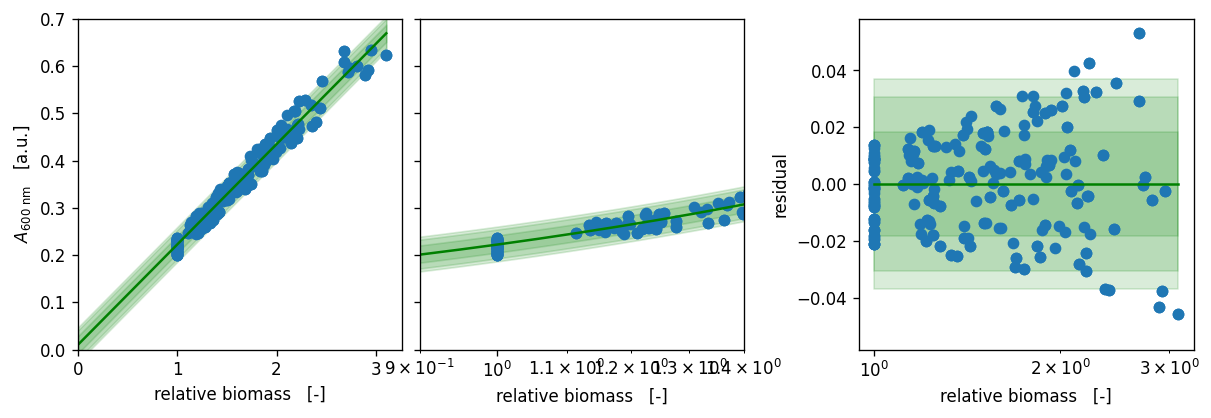

In [7]:
cm_600 = models.LinearBiomassAbsorbanceModel(independent_key="X", dependent_key="A600")
calibr8.fit_scipy(
    cm_600,
    independent=df_rel_biomass.to_numpy().flatten(),
    dependent=df_A600.loc[calibration_rids].to_numpy().flatten(),
    theta_guess=[0.5, 0, 0.2, 3],
    theta_bounds=[
        (0, 2),      # intercept
        (-0.5, 0.5), # slope
        (0.01, 1),   # scale
        (1, 30),     # degree of freedom
    ]
)

plotting.plot_cmodel(cm_600)
cm_600.save("calibration_A600_multibatch.json")

### Plots to make informed guesses about A360/X and A360/P relationships

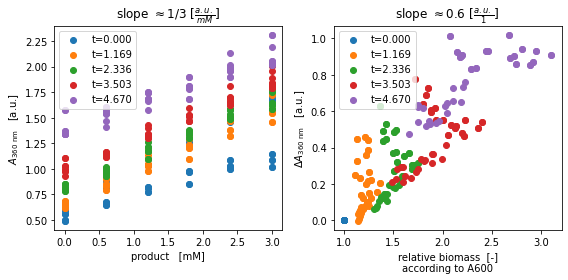

In [8]:
plotting.plot_A360_relationships(df_layout, df_time, df_A360, df_rel_biomass, calibration_rids)

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Oct 07 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.22.0

calibr8   : 6.0.3
pandas    : 1.3.0
matplotlib: 3.4.2
numpy     : 1.21.0
ipywidgets: 7.6.3

Watermark: 2.2.0

